# Flood Frequency and Duration

:::{important}
:class: myclass1,myclass2
:name: appropriated
This file is taken from https://github.com/jpotemra/PCCM/blob/main/Chapter%205%3A%20Sea%20Level/Malakal_SL_FloodFrequency.ipynb to demonstrate how it might work in a juptyer book context.
It is _not_ my own.
:::

Here we will plot several indicators concerning flooding at the Malakal tide gauge, after first taking a general look at the type of data we are able to plot from the UHSLC.

1. Annual flood frequency
2. Intra-annual flood frequency
3. Flood duration

These indicators are based on threshold count, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html).


## Setup

We first need to import the necessary libraries, access the data, and make a quick plot to ensure we will be analyzing the right thing.

### Import necessary libraries.

In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from urllib.request import urlretrieve
from myst_nb import glue

 ###  Next, we'll access data from the UHSLC.

 #TODO: turn this section into a dropdown of available stations to pull from

First, we will access the Malakal data. This tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset.

In [2]:
datadir = './'
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/"
fname = "h007.nc"
path = os.path.join(datadir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path)
    
data_xr = xr.open_dataset(fname)
data_xr

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 476601)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2023-...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 ...
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-11-09T14:34:17Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

and we'll save a few variables that will come up later.

In [3]:
station = str(data_xr.station_name.values)[3:10]
country = str(data_xr.station_country.values)[3:8]
startDateTime = str(data_xr.time.values[0])[:10]
endDateTime = str(data_xr.time.values[-1])[:10]
glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",startDateTime, display=False)
glue("endDateTime",endDateTime, display=False)


###  Plot full time series

Now let's plot all the sea level data.

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in millimeters (mm)! If we want to plot things on a centimeter (cm) scale, we have to divide by 10.
```

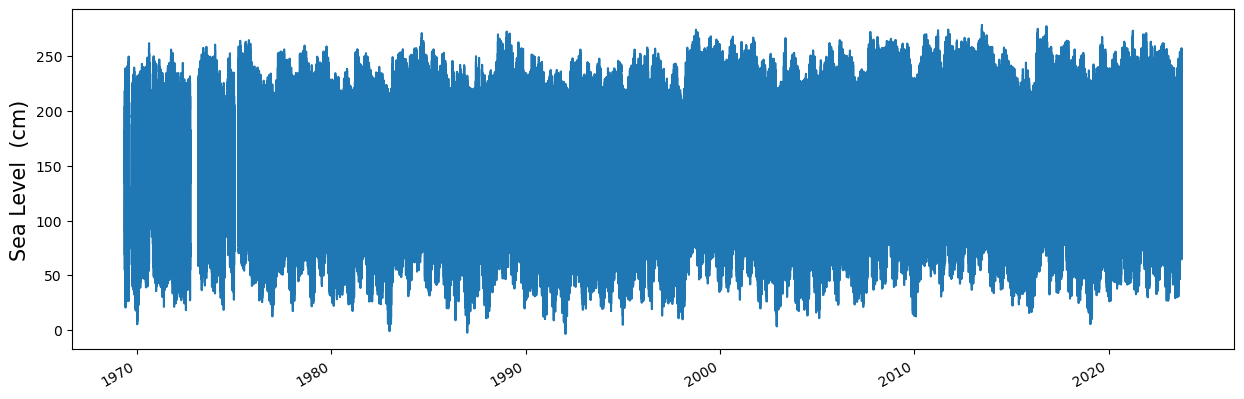

In [4]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(data_xr.time.values,data_xr.sea_level.T.values/10)

ax.set_ylabel('Sea Level  (cm)',fontsize=15)

glue("TS_full_fig", fig, display=False)



```{glue:figure} TS_full_fig
:name: "fig-TS_full"

Full time series at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDateTime` to {glue:text}`endDateTime`. Note that the sea level is plotted in units of cm.
```

### Identify epoch for the flood frequency analysis

Now, we'll calculate trend for the 1993-2022 epoch. We'll do this by taking a slice of the data from Jan-01-1993 to Dec-31-2022, and take a peek at the smaller dataset.


In [5]:
#get data between 1993 and 2022
epoch = [1993,2022]
epoch_start = f"{epoch[0]}-01-01"
epoch_end = f"{epoch[-1]}-12-31"

data_epoch= data_xr.sel(dict(time=slice(epoch_start, epoch_end)))
data_epoch['sea_level'] = data_epoch.sea_level/10 #convert mm to cm
data_epoch

glue("startEpochDateTime",epoch_start, display=False)
glue("endEpochDateTime",epoch_end, display=False)

## Calculate flood frequency counts

This seems like a very matlabby way to do it...?

In [6]:
T = data_epoch.time.values
SL = data_epoch.sea_level.values.T

start_year = epoch[0]
end_year = epoch[-1]
num_years = end_year - start_year + 1
num_months = 12
num_days = 31
num_hours = 24

dat_yyyymmddhh = np.full((num_years, num_months, num_days, num_hours), np.nan)

# Account for Leap Year
daysInMonth_noLeap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
daysInMonth_Leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])


for year in range(num_years):
    if (((year+start_year) % 4 == 0) and ((year+start_year) % 100 != 0)) or ((year+start_year) % 400 == 0):
        calendar = daysInMonth_Leap
    else:
        calendar = daysInMonth_noLeap
    for month in range(num_months):
        # Calculate the effective month index (starting from May)
        effective_month = (month + 4) % 12  # 0-indexed, May corresponds to index 4
        
        # Define the start date for the current month
        if month < 8:
            start_date = np.datetime64(f'{year + start_year}-{effective_month + 1:02d}-01T00:00:00')
        else:
            start_date = np.datetime64(f'{year + start_year+1}-{effective_month + 1:02d}-01T00:00:00')
                
        
         # Calculate the number of days in the current month
        num_days_in_month = calendar[effective_month]
        
         # Calculate the end date for the current month
        end_date = start_date + np.timedelta64(num_days_in_month - 1, 'D') + np.timedelta64(23, 'h') + np.timedelta64(59, 'm') + np.timedelta64(59, 's')

        mask = (T >= start_date) & (T <= end_date)
        if not mask.any():
            dat_yyyymmddhh[year, month, :num_days_in_month, :] = np.nan
        else:
            dat_yyyymmddhh[year, month, :num_days_in_month, :] = SL[mask].reshape((num_days_in_month,num_hours))   
        

```{margin}
```{warning} The threshold used here is hard-coded. What is the data source??
```

In [7]:
#threshold (cm) from  stationary GPD  WHERE DOES THIS DATA COME FROM? 
threshold = 260.9674
glue("threshold",threshold,display=False)
condition_met = dat_yyyymmddhh[:,:,:,:] > threshold
freq_count_yr = np.sum(np.sum(np.sum(condition_met, axis=3),axis=2),axis=1)

### Plot Flood Frequency Counts 

The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year.

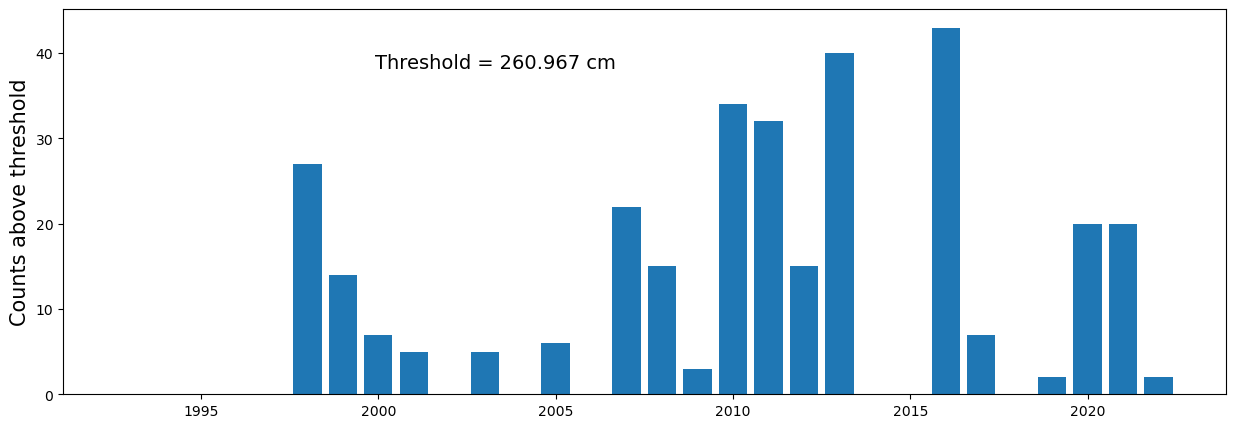

In [8]:
yr = np.arange(epoch[0],epoch[-1]+1)
fig, ax = plt.subplots(figsize=[15,5])
ax.bar(yr,freq_count_yr)
ax.set_ylabel('Counts above threshold',fontsize=15)
ax.annotate(f'Threshold = {np.round(threshold,3)} cm',xy=(.25,.75),xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=14)
glue("threshold_counts_fig", fig, display=False)

```{glue:figure} threshold_counts_fig
:name: "fig-threshold_counts"

Flood frequency counts above a threshold of {glue:text}`threshold:.3f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```